##  Stochastic RNA velocity analysis of dentate gyrus using scvelo

The dataset used in here for velocity analysis is from the dentate gyrus, a part of the hippocampus which is involved in learning, episodic memory formation and spatial coding. <br>
It is measured using 10X Genomics Chromium and described in Hochgerner et al. (2018). The data consists of 25,919 genes across 3,396 cells and provides several interesting characteristics. 

We use a stochastic version of the model for transcriptional dynamics used in velocyto (developed by the Linnarsson lab and Kharchenko Lab).

RNA velocity reference https://www.nature.com/articles/s41586-018-0414-6 <br>
This notebook is based on http://pklab.med.harvard.edu/velocyto/notebooks/R/DG1.nb.html

Files needed: 10X43_1.loom (will be downloaded automatically) <br> 
Optional files: DG_umap.npy, DG_clusters.npy

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import scvelo as scv
scv.logging.print_version()

Running scvelo 0.1.11 on 2018-10-27 12:07.


In [2]:
scv.settings.set_figure_params('scvelo')

## Load and cleanup the data

In [3]:
adata = scv.read("data/DentateGyrus/10X43_1.loom", sparse=True, cache=True, 
                 backup_url="http://pklab.med.harvard.edu/velocyto/DG1/10X43_1.loom")

In [4]:
scv.utils.show_proportions(adata)
scv.utils.cleanup(adata, clean='all')

adata

Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.68 0.08 0.24]


AnnData object with n_obs × n_vars = 3396 × 25919 
    layers: 'spliced', 'unspliced'

## Preprocess the data
- Filter genes by detection and variability; and normalize each cell by total counts.
- Compute moments with neighbor graph in PCA space.

In [5]:
scv.pp.filter_and_normalize(adata, min_counts=20, min_counts_u=10, n_top_genes=5000)

# or run it manually:
# scv.pp.filter_genes(adata, min_counts=10, min_counts_u=5)
# scv.pp.normalize_per_cell(adata)
# scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
# scv.pp.log1p(adata)

filtered out 13864 genes that are detected in less than 20 counts
filtered out 6520 genes that are detected in less than 10 counts(unspliced)


In [6]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing moments based on connectivities
    finished (0:00:00.97) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## Compute velocity and velocity graph
We compute velocity by distinguishing mature from precursor mRNA. We keep the gene that contain predictive information (indicated by correlation between precursor and mature mRNA). We compute cosine correlations between potential cell state changes and corresponding velocities

In [7]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00.15) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [8]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:04.54) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Project the velocity graph onto an embedding

In [9]:
url_data = 'https://github.com/theislab/scvelo_notebooks/raw/master/data/DentateGyrus/'

adata.obs['clusters'] = scv.load('./data/DentateGyrus/DG_clusters.npy', backup_url=url_data + 'DG_clusters.npy')
adata.obsm['X_umap'] = scv.load('./data/DentateGyrus/DG_umap.npy', backup_url=url_data + 'DG_umap.npy')

# or run it manually:
#  scv.tl.louvain(adata)
#  scv.tl.umap(adata, min_dist=1)

In [10]:
scv.tl.velocity_embedding(adata, basis='umap')

computing velocity embedding
    finished (0:00:00.54) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 700x500 with 0 Axes>

## Plot results

... storing 'clusters' as categorical


<Figure size 700x500 with 0 Axes>

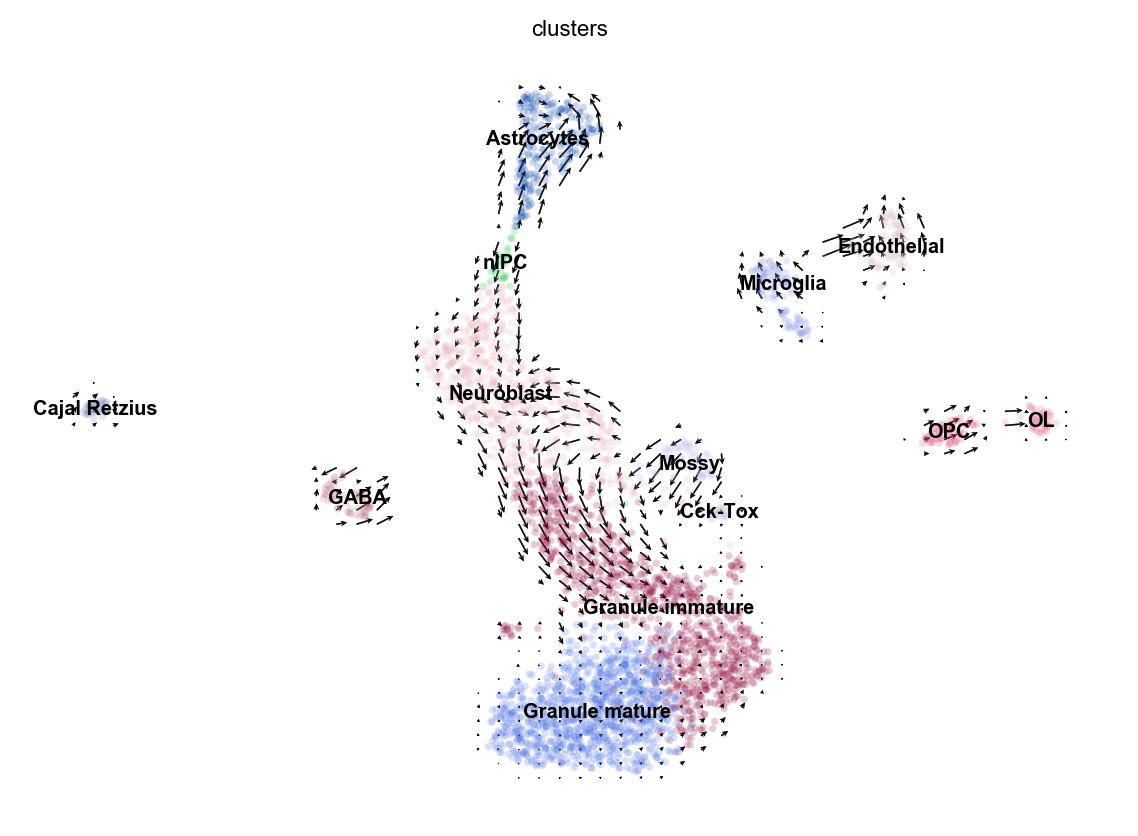

In [11]:
scv.pl.velocity_embedding_grid(adata, legend_loc='on data')

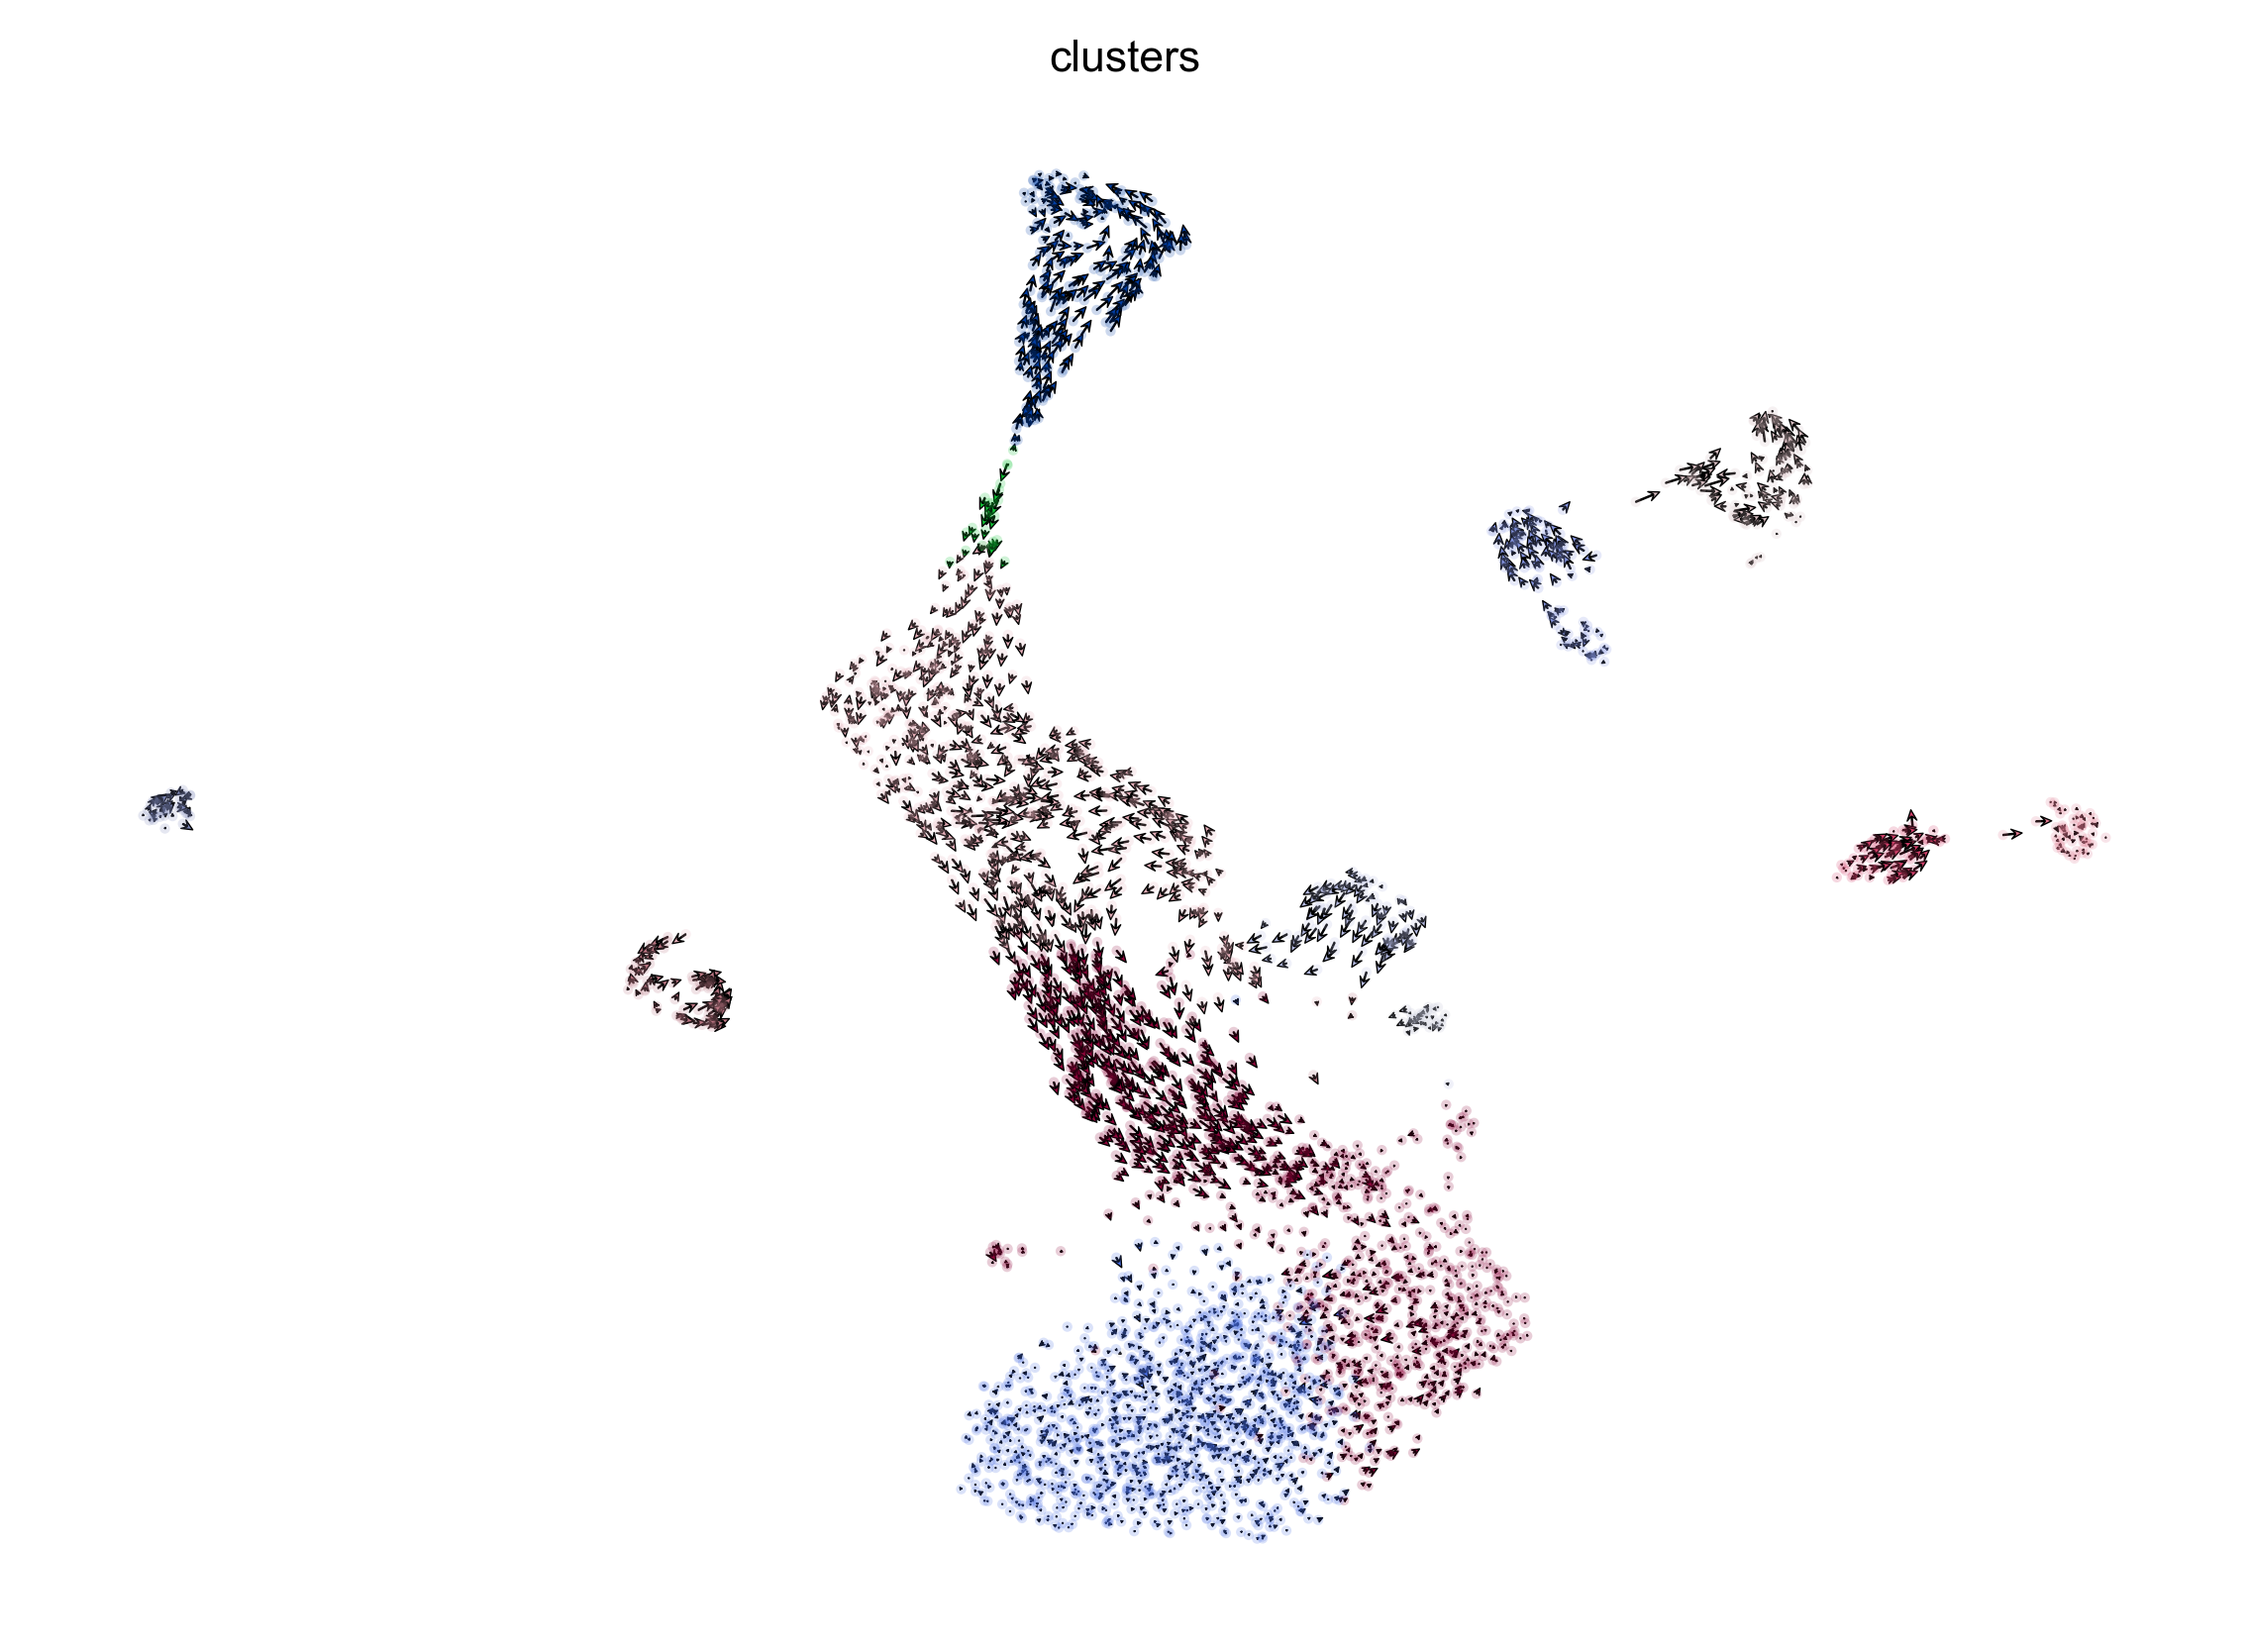

In [12]:
scv.pl.velocity_embedding(adata, dpi=200)

<Figure size 700x500 with 0 Axes>

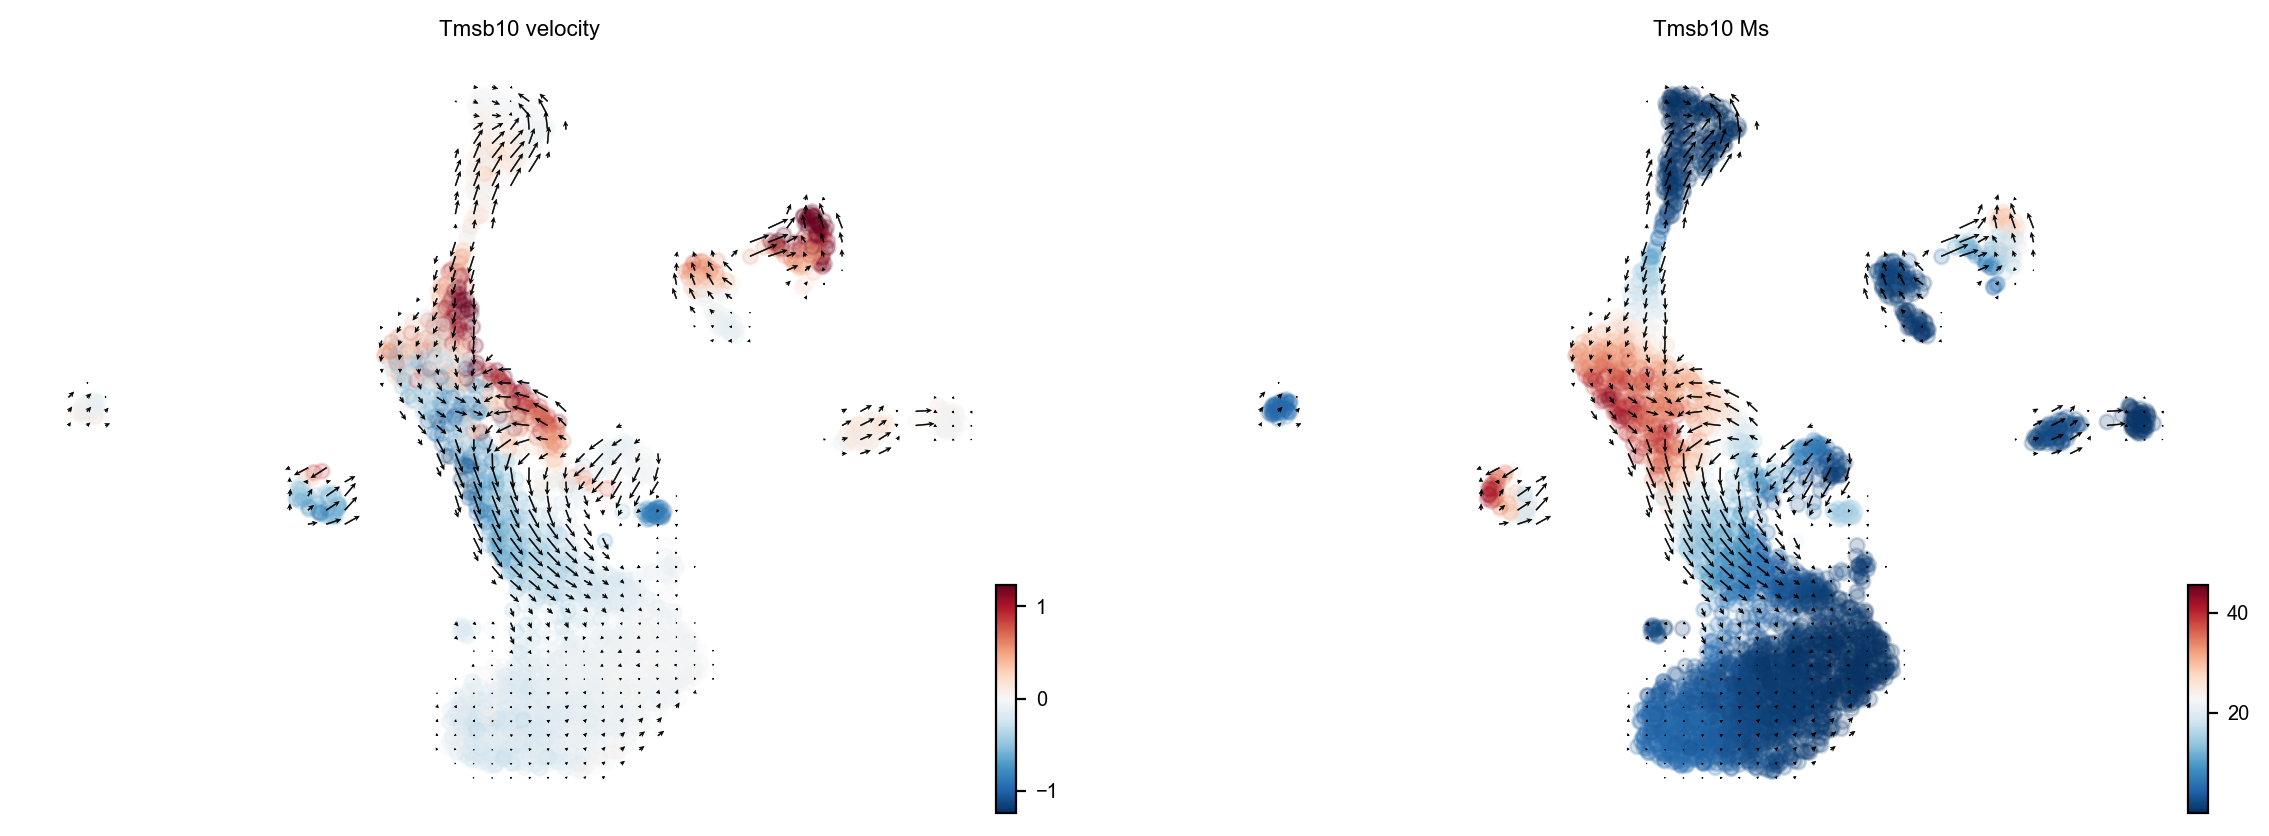

In [13]:
scv.pl.velocity_embedding_grid(adata, color='Tmsb10', layer=['velocity', 'Ms'], colorbar=True)

computing root cells using 4 eigenvectors with eigenvalue 1.
computing end points using 3 eigenvectors with eigenvalue 1.
    finished (0:00:00.57) --> added
    'root', root cells of Markov diffusion process (adata.obs)
    'end', end points of Markov diffusion process (adata.obs)


<Figure size 700x500 with 0 Axes>

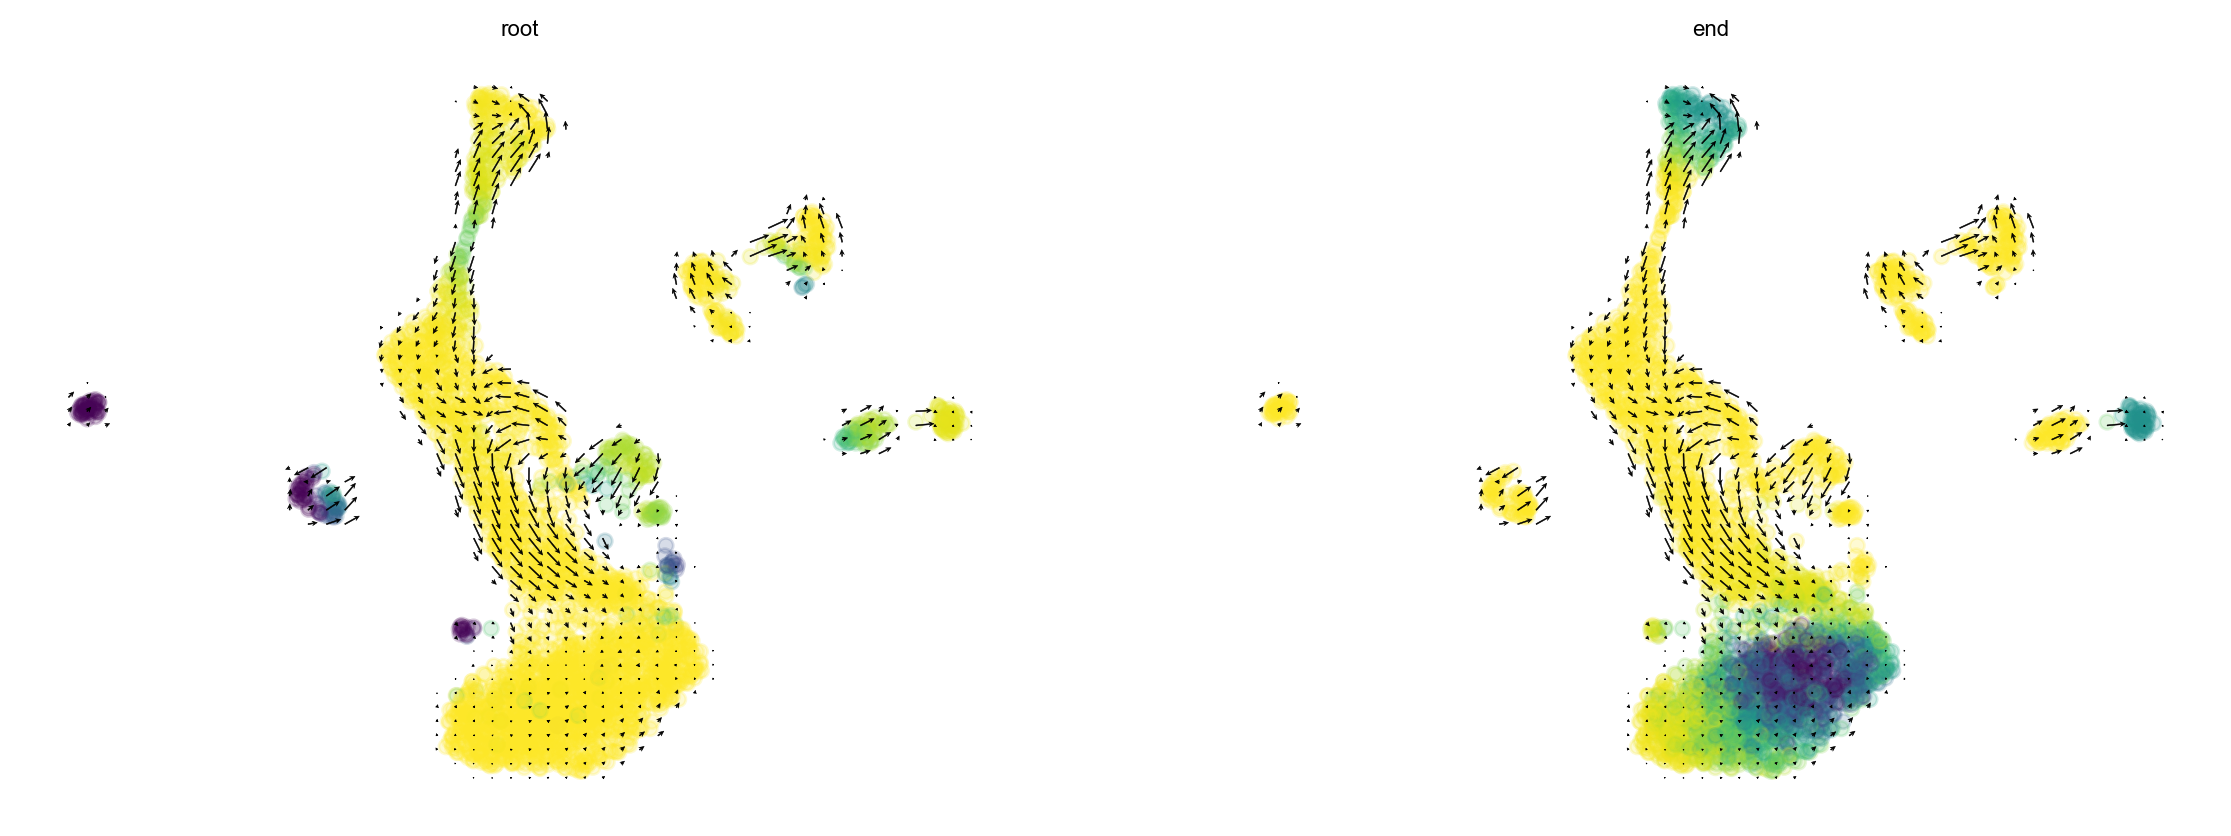

In [14]:
scv.tl.terminal_states(adata)
scv.pl.velocity_embedding_grid(adata, color=['root', 'end'])

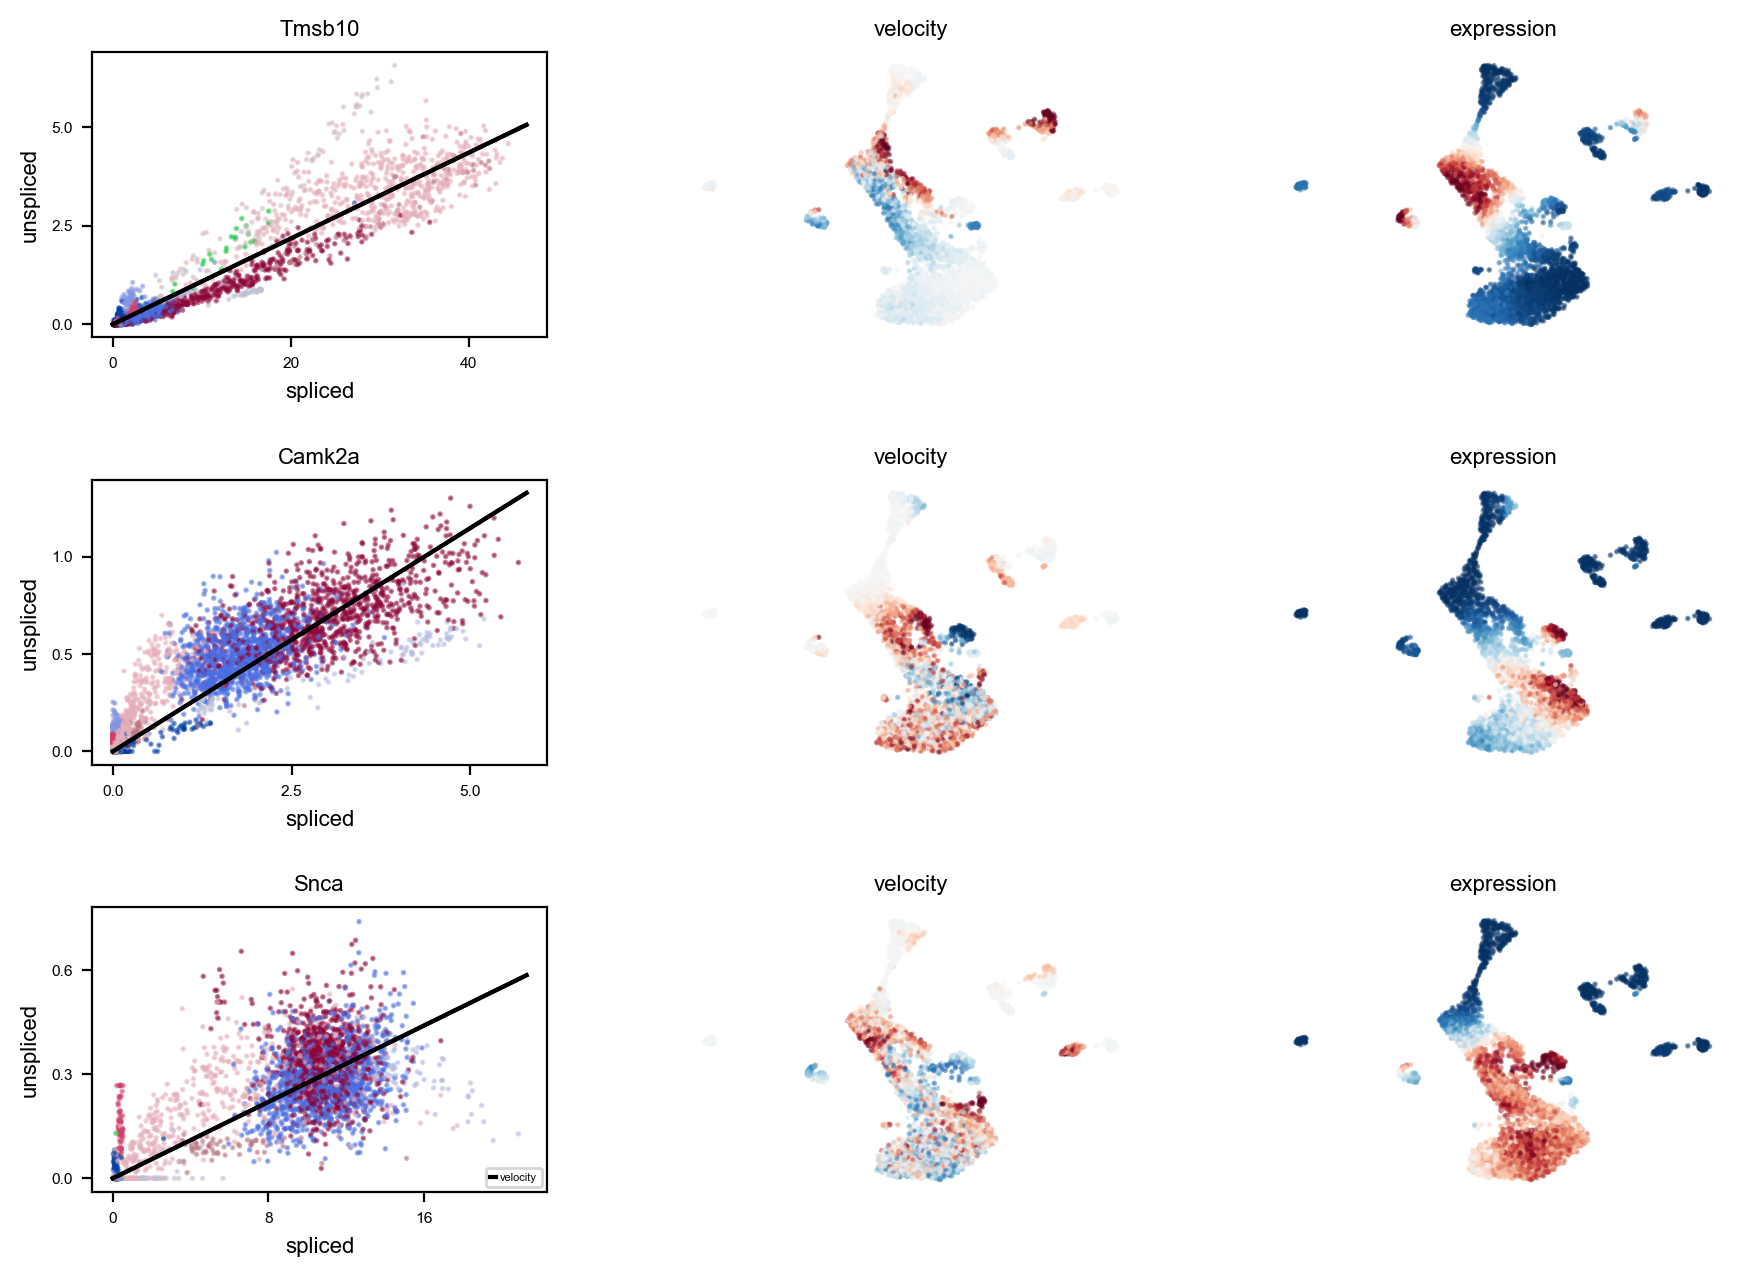

In [15]:
scv.pl.velocity(adata, var_names=['Tmsb10', 'Camk2a', 'Snca'])

In [16]:
import scanpy.api as sc
adata.uns['velocyto_transitions'] = adata.uns['velocity_graph']
sc.tl.paga(adata, groups='clusters')
sc.tl.paga(adata, groups='clusters', use_rna_velocity=True)

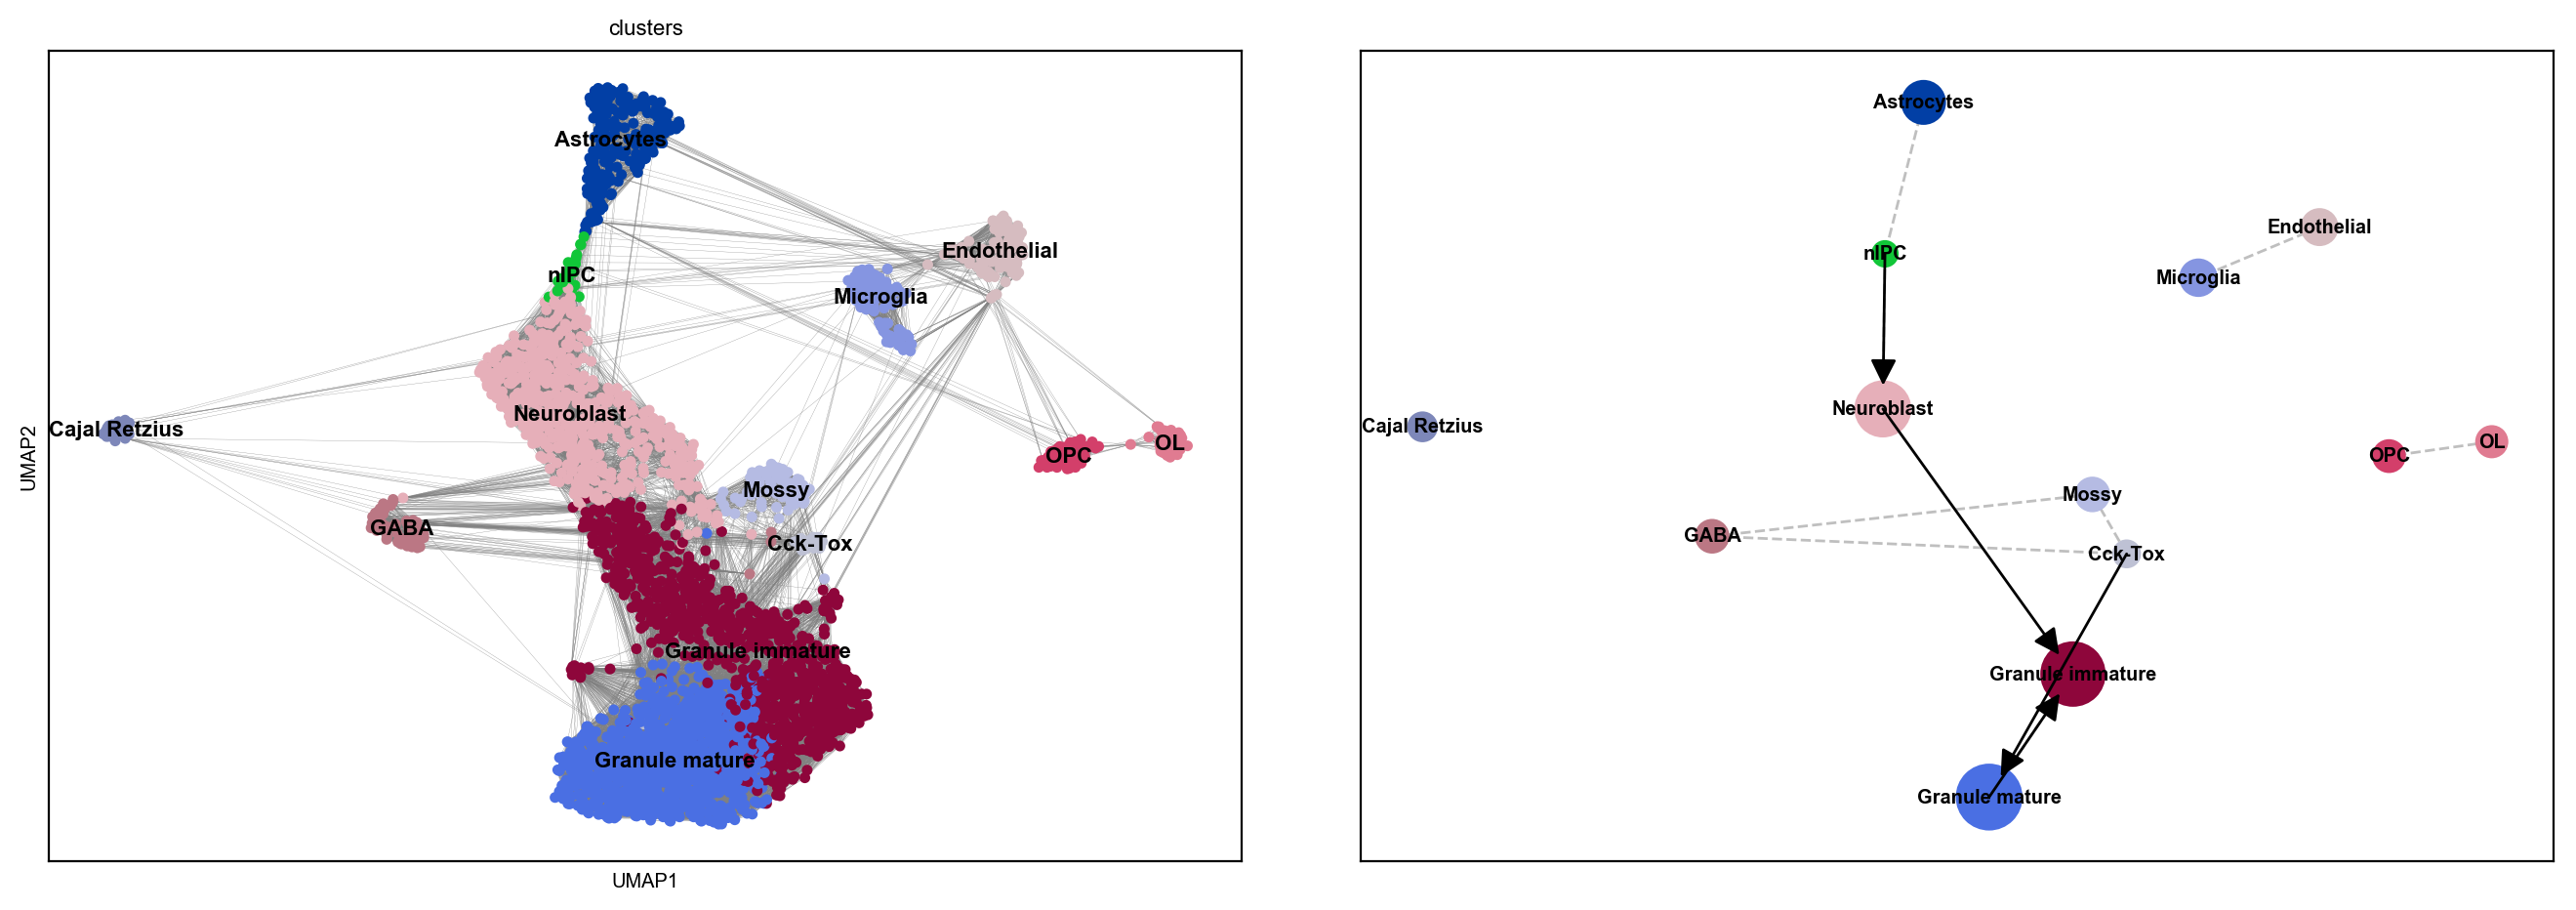

In [17]:
sc.pl.paga_compare(adata, basis='umap', threshold=.2, edges=True, max_edge_width=1, arrowsize=20,
                   transitions='transitions_confidence', dashed_edges='connectivities')